# STITCH PATCHES

In [1]:
# imports
import os
from PIL import Image, ImageDraw
import re
import math
import random
import numpy as np
import torch

In [2]:
# constants
DATASET_PATH = 'dataset/IDC_regular_ps50_idx5'
PATCH_SIZE = 50
SEED = 2022

In [3]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# class that loads an image patch along with some metadata
class ImgPatch:
  def __init__(self, path):
    path_matches = re.match(r'.*[/\\](\d+_idx\d)_x(\d+)_y(\d+)_class(\d)\.png', path)
    assert path_matches is not None, f"Wrong file path format: {path}"
    (patient_id, x_pos, y_pos, is_IDC) = path_matches.groups()
    self.path = path
    self.patient_id = patient_id
    self.x_pos = int(x_pos)
    self.y_pos = int(y_pos)
    self.is_IDC = is_IDC == '1'
    self.img = Image.open(path)

# class that given a patient_id, assembles the full mount slide image from its patches
class Patient:
  def __init__(self, patient_id):
    patient_id = patient_id.replace("_idx5", "")
    patient_path = os.path.join(DATASET_PATH, patient_id)
    assert os.path.isdir(patient_path), f"Could not find '{patient_path}'. Make sure {patient_id} is a valid patient id"
    img_paths = [os.path.join(dirname, filename) for dirname, _, filenames in os.walk(patient_path) for filename in filenames]
    self.img_patches = [ImgPatch(img_path) for img_path in img_paths]
    self.patient_id = patient_id

  def assemble_img(self, highlight_areas = False):
    full_img_width = max(patch.x_pos for patch in self.img_patches) + PATCH_SIZE
    full_img_height = max(patch.y_pos for patch in self.img_patches) + PATCH_SIZE
    full_img = Image.new('RGB', (full_img_width, full_img_height))
    for patch in self.img_patches:
      if highlight_areas:
        draw = ImageDraw.Draw(patch.img, 'RGBA')
        red = (255, 0, 0)
        green = (0, 255, 0)
        highlight_color = red if patch.is_IDC else green
        draw.rectangle((5, 5, 45, 45), fill=highlight_color + (30,), outline=highlight_color, width=2)
      full_img.paste(im=patch.img, box=(patch.x_pos, patch.y_pos))
    return full_img

In [6]:
patient_ids = os.listdir(DATASET_PATH)
# for i in range(10):
#   sample = patient_ids[i]
#   p = Patient(sample)
#   p_img = p.assemble_img(True)
#   p_img.show(title=f"Imatge del pacient {p.patient_id}")
sample = patient_ids[7]
p = Patient("8863")
p_img = p.assemble_img(highlight_areas=False)
p_img.show(title=f"Imatge del pacient {p.patient_id}")


In [6]:
selected = 23
highlight = True
Patient(patient_ids[selected]).assemble_img(highlight_areas=highlight).save(fp=f"./Assembled_{patient_ids[selected]}_{'highlighted' if highlight else 'unhighlighted'}.png")

# EXPLORATORY ANALYSIS

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
patient_data = []

for folder_path, _, filenames in os.walk(DATASET_PATH):
  for filename in filenames:
    file_path = os.path.join(folder_path, filename)
    path_matches = re.match(r'.*[/\\](\d+_idx\d)_x(\d+)_y(\d+)_class(\d)\.png', file_path)
    (patient_id, x_pos, y_pos, is_IDC) = path_matches.groups()
    patient_data.append((patient_id, file_path, int(x_pos), int(y_pos), is_IDC == '1'))
  

patients_df = pd.DataFrame(data=patient_data, columns=["patient_id", "file_path", "x_pos", "y_pos", "is_IDC"])

print(patients_df.shape)

(277524, 5)


In [9]:
print("Carregant les dimensions de les imatges... Això pot tardar uns minuts...")
patients_df['img_width'] = patients_df['file_path'].apply(lambda fp: Image.open(fp).size[0])
patients_df['img_height'] = patients_df['file_path'].apply(lambda fp: Image.open(fp).size[1])

patients_df.head(10)

Carregant les dimensions de les imatges... Això pot tardar uns minuts...


,patient_id,file_path,x_pos,y_pos,is_IDC,img_width,img_height
0,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1001,False,50,50
1,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1051,False,50,50
2,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1101,False,50,50
3,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1151,False,50,50
4,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1201,False,50,50
5,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1251,False,50,50
6,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1301,False,50,50
7,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1351,False,50,50
8,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1501,False,50,50
9,10253_idx5,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,1001,1551,False,50,50


In [10]:
# Imagtes que no són 50x50 px
correct_size_imgs = patients_df.loc[(patients_df['img_height'] == 50) & (patients_df['img_width'] == 50)]
wrong_size_imgs = patients_df.loc[(patients_df['img_height'] != 50) | (patients_df['img_width'] != 50)]

total_count = patients_df.shape[0]
correct_count = correct_size_imgs.shape[0]
wrong_count = wrong_size_imgs.shape[0]

print(f"El joc de dades té un total de {total_count} imatges")
print(f"D'aquestes, {correct_count} tenen una mida de 50x50 píxels ({(100 * correct_count / total_count):.2f}%)")
print(f"Les {wrong_count} restants no tenen una mida de 50x50 píxels ({(100 * wrong_count / total_count):.2f}%)")

El joc de dades té un total de 277524 imatges
D'aquestes, 275222 tenen una mida de 50x50 píxels (99.17%)
Les 2302 restants no tenen una mida de 50x50 píxels (0.83%)


In [11]:
# No hi ha cap imatge d'alçada o amplada major de 50px
patients_df.loc[(patients_df['img_height'] > 50) | (patients_df['img_width'] > 50)]

,patient_id,file_path,x_pos,y_pos,is_IDC,img_width,img_height


In [12]:
print(correct_size_imgs.shape)

(275222, 7)


In [13]:
total_count = patients_df.shape[0]
positive_count = patients_df.value_counts(subset="is_IDC")[True]
negative_count = patients_df.value_counts(subset="is_IDC")[False]

print(f"De les {total_count} imatges que formen el joc de dades, {positive_count} són CDI-positives ({(100*positive_count / total_count):.2f}%), i {negative_count} són CDI-negatives ({(100*negative_count / total_count):.2f})")

De les 277524 imatges que formen el joc de dades, 78786 són CDI-positives (28.39%), i 198738 són CDI-negatives (71.61)


In [14]:
patients_df['mean_IDC'] = patients_df.groupby('patient_id')['is_IDC'].transform('mean')

sorted_by_IDC = patients_df.sort_values('mean_IDC', ascending=False)

most_IDC_patient = sorted_by_IDC.iloc[0]
least_IDC_patient = sorted_by_IDC.iloc[-1]


print(f"El pacient {most_IDC_patient.loc['patient_id']} és el que té més proporció d'imatges IDC positives, amb el {(most_IDC_patient.loc['mean_IDC'] * 100):.2f}% de les imatges contenint cèl·lules afectades pel càncer")
print(f"El pacient {least_IDC_patient.loc['patient_id']} és el que té menys proporció d'imatges IDC positives, amb el {(least_IDC_patient.loc['mean_IDC'] * 100):.2f}% de les imatges contenint cèl·lules afectades pel càncer")
print(f"La mitjana de tots els pacients és del {(sorted_by_IDC['is_IDC'].mean() * 100):.2f}%")

print(patients_df['mean_IDC'].describe())
# Eliminem la columna auxiliar 'mean_IDC'
del patients_df['mean_IDC']

El pacient 14209_idx5 és el que té més proporció d'imatges IDC positives, amb el 90.35% de les imatges contenint cèl·lules afectades pel càncer
El pacient 10305_idx5 és el que té menys proporció d'imatges IDC positives, amb el 1.04% de les imatges contenint cèl·lules afectades pel càncer
La mitjana de tots els pacients és del 28.39%
count    277524.000000
mean          0.283889
std           0.195396
min           0.010434
25%           0.124390
50%           0.236870
75%           0.417266
max           0.903509
Name: mean_IDC, dtype: float64


In [15]:
# Imatge del pacient amb major percentatge de cèl·lules afectades pel IDC
Patient(most_IDC_patient.loc["patient_id"]).assemble_img(highlight_areas=True).show()
# Imatge del pacient amb menor percentatge de cèl·lules afectades pel IDC
Patient(least_IDC_patient.loc["patient_id"]).assemble_img(highlight_areas=True).show()

<AxesSubplot: title={'center': "Nombre d'imatges per pacient"}, xlabel='patient_id'>

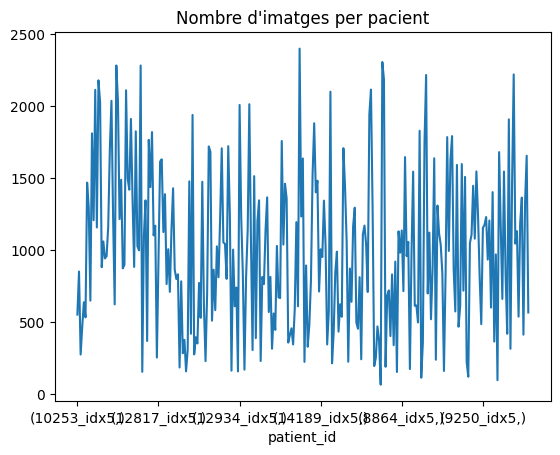

In [16]:
# patients_df.groupby('patient_id').agg({ 'is_IDC': ['mean', 'min', 'max']})
# patients_df.groupby('patient_id')['is_IDC'].describe()
patients_df.value_counts(subset=['patient_id'], sort=False).plot(title="Nombre d'imatges per pacient")

<AxesSubplot: >

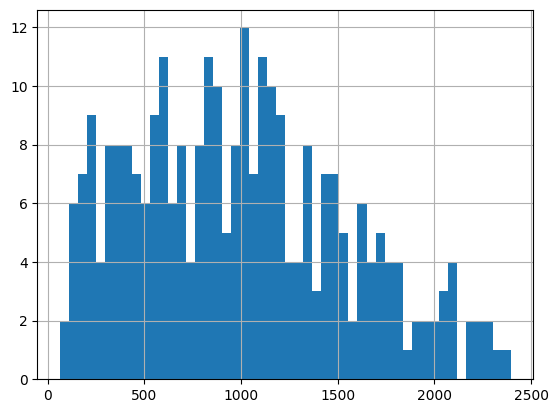

In [17]:
# Histograma on es veu la distribució del nombre d'imatges que té cada pacient
patients_df.groupby('patient_id').count()['file_path'].sort_values().hist(bins=50)

In [18]:
# Info sobre el nombre de imatges que tenen els pacients
patients_df.groupby('patient_id').count()['file_path'].describe()

count     279.000000
mean      994.709677
std       550.603474
min        63.000000
25%       560.500000
50%       967.000000
75%      1362.000000
max      2395.000000
Name: file_path, dtype: float64

In [19]:

patients_df.groupby('patient_id').count()['file_path'].sort_values()

patient_id
16534_idx5      63
9262_idx5       94
8957_idx5      111
9175_idx5      118
16895_idx5     151
              ... 
9323_idx5     2216
10288_idx5    2278
10308_idx5    2278
16550_idx5    2302
13693_idx5    2395
Name: file_path, Length: 279, dtype: int64

<AxesSubplot: title={'center': "Ratio d'imatges amb IDC positiu o negatiu per pacient"}, xlabel='patient_id'>

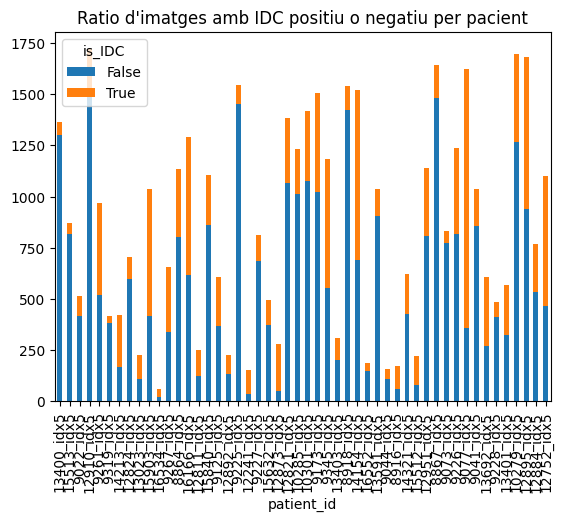

In [20]:
patients_df.groupby(['patient_id', 'is_IDC'])['patient_id'].count().unstack('is_IDC').sample(50, random_state=SEED).plot(kind='bar', stacked=True, title="Ratio d'imatges amb IDC positiu o negatiu per pacient")

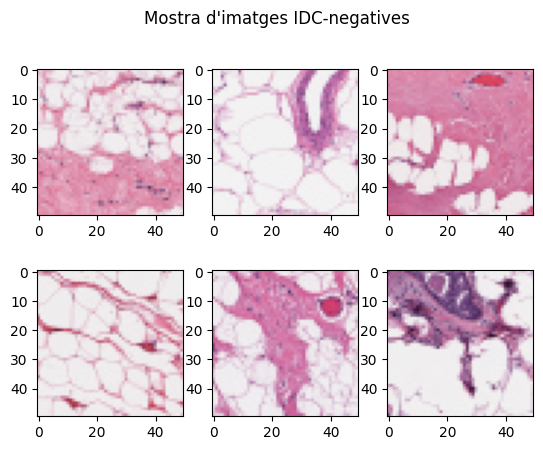

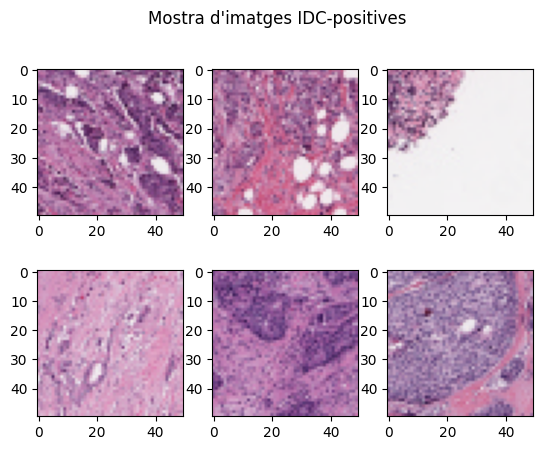

In [21]:
def show_sample_img_grid(df, grid_size=(3, 3), title="Mostra d'imatges", file_path_col="file_path"):
  (row_count, col_count) = grid_size

  sampled_df = df.sample(row_count * col_count, random_state=SEED)

  fig, img_grid = plt.subplots(row_count, col_count)
  fig.suptitle(title)

  for i in range(row_count):
    for j in range(col_count):
      img_grid[i, j].imshow(Image.open(sampled_df.iloc[i * col_count + j][file_path_col]))

  plt.show()


neg_IDC_df = patients_df.loc[~patients_df['is_IDC'],]
pos_IDC_df = patients_df.loc[patients_df['is_IDC'],]

show_sample_img_grid(neg_IDC_df, title="Mostra d'imatges IDC-negatives", grid_size=(2,3))
show_sample_img_grid(pos_IDC_df, title="Mostra d'imatges IDC-positives", grid_size=(2,3))

In [22]:
fp = patients_df.iloc[0]['file_path']
img_arr = np.array(Image.open(fp))

print(img_arr.shape)
print(type(img_arr[0][0][0]))
img_arr = img_arr / 2
img_arr = img_arr.astype(np.uint8)
print(img_arr.shape)
# img_arr = img_arr.reshape((50, 50, 3))
print(img_arr.shape)

print(img_arr)


Image.fromarray(img_arr, 'RGB').show()

(50, 50, 3)
<class 'numpy.uint8'>
(50, 50, 3)
(50, 50, 3)
[[[113  82 103]
  [112  77  98]
  [112  87 105]
  ...
  [120 110 118]
  [116  92 107]
  [121 106 117]]

 [[108  71  94]
  [110  65  89]
  [112  75  98]
  ...
  [113  85 102]
  [114  90 107]
  [118 106 116]]

 [[118  89 106]
  [114  78  99]
  [109  62  87]
  ...
  [110  92 108]
  [ 95  76  96]
  [113  82 104]]

 ...

 [[108  72  96]
  [107  64  92]
  [106  64  91]
  ...
  [ 97  61  92]
  [102  71  96]
  [ 94  64  94]]

 [[109  72  96]
  [106  64  92]
  [104  60  85]
  ...
  [ 68  39  72]
  [ 92  55  87]
  [ 94  56  88]]

 [[106  62  90]
  [105  68  90]
  [110  81 103]
  ...
  [ 63  45  76]
  [106  83 101]
  [107  90 105]]]
